<a href="https://colab.research.google.com/github/coachsummer/Project-X/blob/main/001_Medical%20No%20Show/001_Medical_No_Show.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
import seaborn as sns

import datetime
from time import strftime

from google.colab import drive
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

## 01_Data Store

In [2]:
drive.mount('/gdrive', force_remount = True)
working_dir = 'noshow'
colab_default_dir = '/gdrive/My Drive/Colab Notebooks/'
original_dir = os.getcwd()

Mounted at /gdrive


In [3]:
try:
  os.chdir(colab_default_dir)
  if not os.path.exists(working_dir):
    os.mkdir(working_dir)
  os.chdir(working_dir)
  print('current dir = ', os.getcwd())
except Exception as err:
  os.chdir(original_dir)
  print(str(err))

current dir =  /gdrive/My Drive/Colab Notebooks/noshow


In [4]:
NSdf = pd.read_csv('medical no show.csv')

## 02_Data Explore & Preprocess

In [5]:
NSdf.info()
NSdf.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
42297,2.787789e+13,5703178,M,2016-05-16T13:36:23Z,2016-05-16T00:00:00Z,1,MARIA ORTIZ,0,0,0,0,0,0,No
47786,8.496817e+13,5666507,F,2016-05-05T17:19:36Z,2016-05-25T00:00:00Z,63,MARUÍPE,0,0,0,0,0,1,No
70232,4.678419e+13,5706177,M,2016-05-17T07:57:57Z,2016-05-17T00:00:00Z,15,MARUÍPE,0,0,0,0,0,0,No
5809,3.754141e+13,5679805,M,2016-05-10T10:31:21Z,2016-05-10T00:00:00Z,0,JESUS DE NAZARETH,0,0,0,0,0,0,No
55438,3.448634e+13,5482949,F,2016-03-17T10:33:12Z,2016-05-16T00:00:00Z,24,SANTA CECÍLIA,0,0,0,0,0,0,No
1417,6.121290e+11,5542250,F,2016-04-05T08:46:42Z,2016-04-29T00:00:00Z,67,DO QUADRO,0,1,0,0,0,1,No
76062,3.346536e+13,5642775,F,2016-04-29T17:10:45Z,2016-05-09T00:00:00Z,0,SÃO PEDRO,0,0,0,0,0,0,No
65860,6.416434e+13,5604510,F,2016-04-20T08:03:01Z,2016-05-06T00:00:00Z,39,TABUAZEIRO,0,0,0,0,0,1,No
9812,1.231779e+14,5743404,F,2016-05-30T08:59:12Z,2016-05-30T00:00:00Z,30,ROMÃO,1,0,0,0,0,0,No
58756,5.499857e+12,5596750,F,2016-04-18T15:12:45Z,2016-05-16T00:00:00Z,0,MARIA ORTIZ,0,0,0,0,0,0,No


In [6]:
NSdf.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


오타 수정

In [7]:
NSdf = NSdf.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [8]:
NSdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hypertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handicap        110527 non-null  int64  
 12  SMSReceived     110527 non-null  int64  
 13  NoShow          110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [9]:
NSdf.columns.ravel()

array(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship',
       'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap',
       'SMSReceived', 'NoShow'], dtype=object)

필요 없는 데이터 삭제

In [10]:
#시스템이 생성한 숫자이므로 필요없다. 삭제
NSdf.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)

데이터 타입을 학습에 맞게 변환

In [11]:
NSdf['ScheduledDay'] = pd.to_datetime(NSdf['ScheduledDay']).dt.date.astype('datetime64[ns]')
NSdf['AppointmentDay'] = pd.to_datetime(NSdf['AppointmentDay']).dt.date.astype('datetime64[ns]')

In [12]:
#고유값 확인
print("Gender: {}".format(NSdf.Gender.unique()))
print("Scholarship: {}".format(NSdf.Scholarship.unique()))
print("Hypertension: {}".format(NSdf.Hypertension.unique()))
print("Diabetes: {}".format(NSdf.Diabetes.unique()))
print("Alcoholism: {}".format(NSdf.Alcoholism.unique()))
print("Handicap: {}".format(NSdf.Handicap.unique()))
print("SMSReceived: {}".format(NSdf.SMSReceived.unique()))

Gender: ['F' 'M']
Scholarship: [0 1]
Hypertension: [1 0]
Diabetes: [0 1]
Alcoholism: [0 1]
Handicap: [0 1 2 3 4]
SMSReceived: [0 1]


In [13]:
#참 거짓에 대한 데이터는 object형으로 변환
NSdf['Scholarship'] = NSdf['Scholarship'].astype('object')
NSdf['Hypertension'] = NSdf['Hypertension'].astype('object')
NSdf['Diabetes'] = NSdf['Diabetes'].astype('object')
NSdf['Alcoholism'] = NSdf['Alcoholism'].astype('object')
NSdf['Handicap'] = NSdf['Handicap'].astype('object')
NSdf['SMSReceived'] = NSdf['SMSReceived'].astype('object')
NSdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Gender          110527 non-null  object        
 1   ScheduledDay    110527 non-null  datetime64[ns]
 2   AppointmentDay  110527 non-null  datetime64[ns]
 3   Age             110527 non-null  int64         
 4   Neighbourhood   110527 non-null  object        
 5   Scholarship     110527 non-null  object        
 6   Hypertension    110527 non-null  object        
 7   Diabetes        110527 non-null  object        
 8   Alcoholism      110527 non-null  object        
 9   Handicap        110527 non-null  object        
 10  SMSReceived     110527 non-null  object        
 11  NoShow          110527 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(9)
memory usage: 10.1+ MB


In [14]:
NSdf.sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
4515,F,2016-05-25,2016-05-31,58,JESUS DE NAZARETH,0,1,0,0,0,1,No
59689,M,2016-05-24,2016-05-24,14,PRAIA DO CANTO,0,0,0,0,0,0,No
50073,F,2016-05-02,2016-05-02,2,JARDIM DA PENHA,0,0,0,0,0,0,No
53808,M,2016-03-30,2016-05-02,70,MARIA ORTIZ,0,0,0,0,0,1,No
52196,F,2016-05-18,2016-05-18,73,JARDIM DA PENHA,0,0,0,0,0,0,No


데이터 에러 검사 및 수정

In [15]:
np.sort(NSdf.Age.unique())

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 115])

In [16]:
#0살 -1살이 있다. 몇개나 있는지 알아보자.
print(NSdf[NSdf.Age == -1].shape[0])
print(NSdf[NSdf.Age == 0].shape[0])

1
3539


In [17]:
#-1살은 1명 나왔다. 오타인 듯 하다. 삭제
NSdf = NSdf[NSdf.Age >= 0]

예약날짜 데이터 탐색

In [18]:
np.sort(NSdf.ScheduledDay.dt.strftime('%Y-%m-%d').unique())

array(['2015-11-10', '2015-12-03', '2015-12-07', '2015-12-08',
       '2015-12-14', '2015-12-15', '2016-01-04', '2016-01-05',
       '2016-01-07', '2016-01-11', '2016-01-13', '2016-01-14',
       '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22',
       '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28',
       '2016-01-29', '2016-02-01', '2016-02-02', '2016-02-03',
       '2016-02-04', '2016-02-05', '2016-02-11', '2016-02-12',
       '2016-02-15', '2016-02-16', '2016-02-17', '2016-02-18',
       '2016-02-19', '2016-02-22', '2016-02-23', '2016-02-24',
       '2016-02-25', '2016-02-26', '2016-02-29', '2016-03-01',
       '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05',
       '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10',
       '2016-03-11', '2016-03-14', '2016-03-15', '2016-03-16',
       '2016-03-17', '2016-03-18', '2016-03-19', '2016-03-21',
       '2016-03-22', '2016-03-23', '2016-03-28', '2016-03-29',
       '2016-03-30', '2016-03-31', '2016-04-01', '2016-

In [19]:
#예약날짜를 확인하니 대략 7개월 정도의 간격이 있다.

진료날짜 데이터 탐색

In [20]:
np.sort(NSdf.AppointmentDay.dt.strftime('%Y-%m-%d').unique())

array(['2016-04-29', '2016-05-02', '2016-05-03', '2016-05-04',
       '2016-05-05', '2016-05-06', '2016-05-09', '2016-05-10',
       '2016-05-11', '2016-05-12', '2016-05-13', '2016-05-14',
       '2016-05-16', '2016-05-17', '2016-05-18', '2016-05-19',
       '2016-05-20', '2016-05-24', '2016-05-25', '2016-05-30',
       '2016-05-31', '2016-06-01', '2016-06-02', '2016-06-03',
       '2016-06-06', '2016-06-07', '2016-06-08'], dtype=object)

In [21]:
#진료약속날짜를 확인하니 대략 1달 정도 간격이 있다.

지역 데이터 탐색

In [22]:
# 지역을 살펴보자.
np.sort(NSdf.Neighbourhood.unique())
NSdf.Neighbourhood.unique().size

81

예약 요일, 진료 요일 데이터 생성

In [23]:
# 요일과 상관관계가 있을지도 모른다. 요일로 데이터 만들자.
NSdf['ScheduledDay_DOW'] = NSdf['ScheduledDay'].dt.day_name()
NSdf['AppointmentDay_DOW'] = NSdf['AppointmentDay'].dt.day_name()

예약, 진료 날짜에 대한 에러 보정

In [24]:
#진료약속날짜는 예약일의 이후의 날짜여야 한다.
#만약 예약날짜가 진료약속날짜보다 이후이면 에러로 간주하고 진료약속날짜를 예약날짜로 바꾼다.
NSdf['AppointmentDay'] = np.where((NSdf['AppointmentDay'] - NSdf['ScheduledDay']).dt.days < 0, NSdf['ScheduledDay'], NSdf['AppointmentDay'])

대기 기간 데이터 생성

In [25]:
#환자가 기다리는 기다리는 날들도 영향을 미칠 수 있으니 데이터로 생성한다.
NSdf['Waiting_Time_days'] = NSdf['AppointmentDay'] - NSdf['ScheduledDay']
NSdf['Waiting_Time_days'] = NSdf['Waiting_Time_days'].dt.days

## 03_Data Analysis

In [26]:
NSdf.info()
NSdf.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Gender              110526 non-null  object        
 1   ScheduledDay        110526 non-null  datetime64[ns]
 2   AppointmentDay      110526 non-null  datetime64[ns]
 3   Age                 110526 non-null  int64         
 4   Neighbourhood       110526 non-null  object        
 5   Scholarship         110526 non-null  object        
 6   Hypertension        110526 non-null  object        
 7   Diabetes            110526 non-null  object        
 8   Alcoholism          110526 non-null  object        
 9   Handicap            110526 non-null  object        
 10  SMSReceived         110526 non-null  object        
 11  NoShow              110526 non-null  object        
 12  ScheduledDay_DOW    110526 non-null  object        
 13  AppointmentDay_DOW  110526 no

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
27370,F,2016-05-05,2016-05-13,37,CONQUISTA,0,0,0,0,0,0,No,Thursday,Friday,8
72916,F,2016-05-19,2016-05-19,29,SANTA MARTHA,1,1,0,0,0,0,No,Thursday,Thursday,0
62987,F,2016-03-01,2016-05-06,44,JARDIM CAMBURI,0,0,0,0,0,1,No,Tuesday,Friday,66
24876,F,2016-05-30,2016-05-30,15,MARIA ORTIZ,0,0,0,0,0,0,No,Monday,Monday,0
11568,F,2016-05-06,2016-05-06,71,JUCUTUQUARA,0,0,0,0,0,0,No,Friday,Friday,0
22124,F,2016-04-27,2016-05-02,36,GURIGICA,1,0,0,0,0,1,Yes,Wednesday,Monday,5
80663,F,2016-04-27,2016-05-05,60,ITARARÉ,0,1,0,0,0,1,No,Wednesday,Thursday,8
2298,F,2016-04-27,2016-04-29,74,JARDIM DA PENHA,0,1,1,0,0,0,No,Wednesday,Friday,2
80857,M,2016-05-10,2016-05-13,77,DA PENHA,0,1,1,0,0,0,No,Tuesday,Friday,3
34458,M,2016-04-25,2016-05-30,90,TABUAZEIRO,0,1,0,0,0,1,Yes,Monday,Monday,35


In [27]:
#no Show를 세어보자.
print("NoShow and Show Count of Patients\n")
print(NSdf.groupby(['NoShow']).size())

NoShow and Show Count of Patients

NoShow
No     88207
Yes    22319
dtype: int64


In [28]:
#no Show를 확률로 보자.
show = NSdf.groupby(['NoShow']).size()[0]/(NSdf.groupby(['NoShow']).size()[0]+NSdf.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = NSdf.groupby(['NoShow']).size()[1]/(NSdf.groupby(['NoShow']).size()[0]+NSdf.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


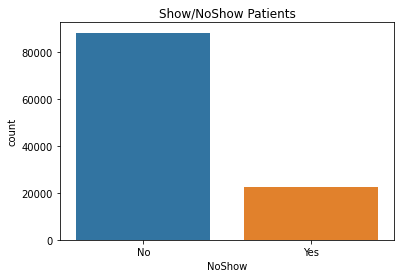

In [29]:
ax = sns.countplot(x=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow Patients")
plt.show()

예약을 지킨 경우는 79.81%, 지키지 않은 경우는 20.19%이다.

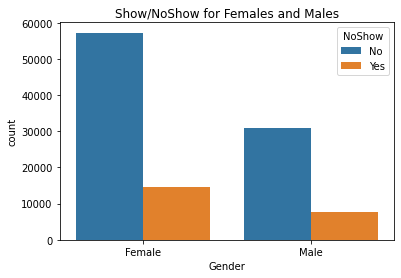

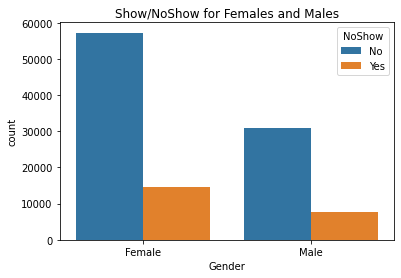

In [30]:
#노쇼를 성별로 보자
ax = sns.countplot(x=NSdf.Gender, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()
ax = sns.countplot(x=NSdf.Gender, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Females and Males")
x_ticks_labels=['Female', 'Male']
ax.set_xticklabels(x_ticks_labels)
plt.show()

여성이 병원 예약을 더욱 많이 하지만 Noshow의 확률은 성별과 별로 상관이 없어 보인다.

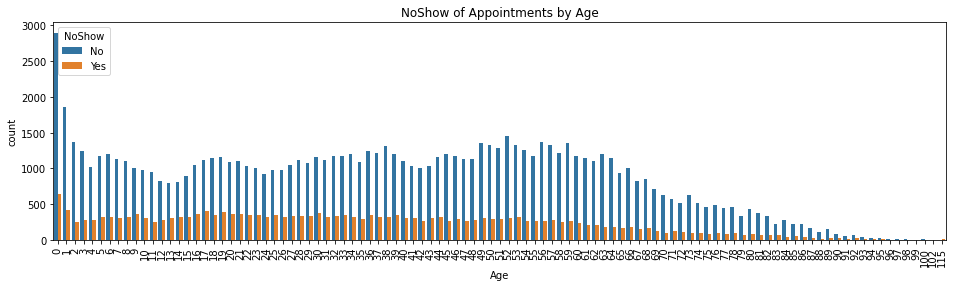

In [31]:
# 나이에 따른 확률적인 분포 확인하기
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=NSdf.Age, hue=NSdf.NoShow)
ax.set_title("NoShow of Appointments by Age")
plt.show()

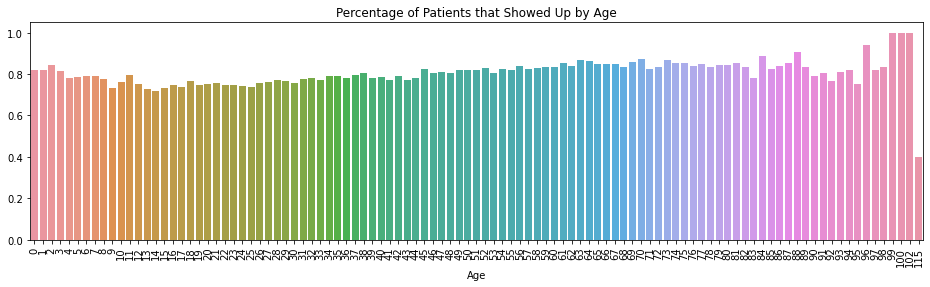

In [32]:
#연령별 no show 확률 그래프
NSdf_age_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Age']).size()/NSdf.groupby(['Age']).size()
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=NSdf_age_ratio.index, y=NSdf_age_ratio)
ax.set_title("Percentage of Patients that Showed Up by Age")
plt.show()

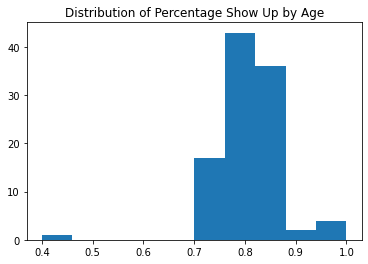

In [33]:
#plt.figure(figsize=(10,4))
#plt.xticks(rotation=90)
ax = plt.hist(NSdf_age_ratio)
plt.title("Distribution of Percentage Show Up by Age")
plt.show()

나이에 상관없이 꾸준히 80% 정도의 예약을 지키고 있다. 나이가 100살 가까이 가면 Noshow는 거의 없으나 115살은 예외인 것을 보니 병원을 오다가 사고가 난 듯 싶다.

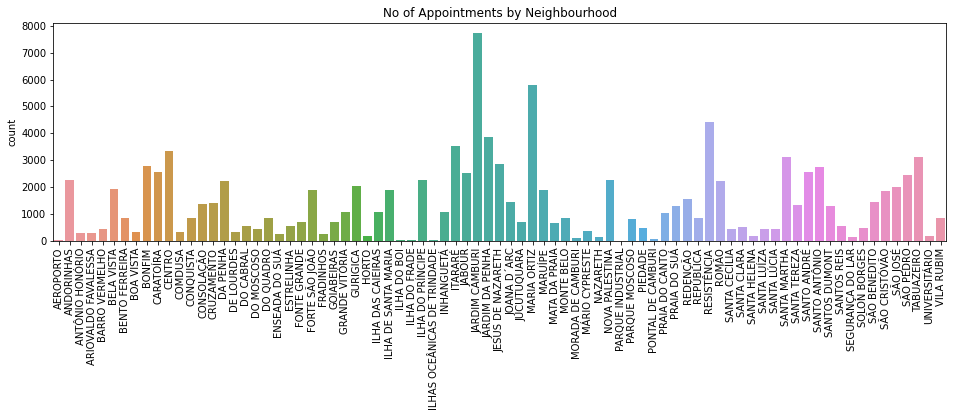

In [34]:
#지역에 대한 NSdf 그래프지역에 대한 NSdf 그래프
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=np.sort(NSdf.Neighbourhood))
ax.set_title("No of Appointments by Neighbourhood")
plt.show()

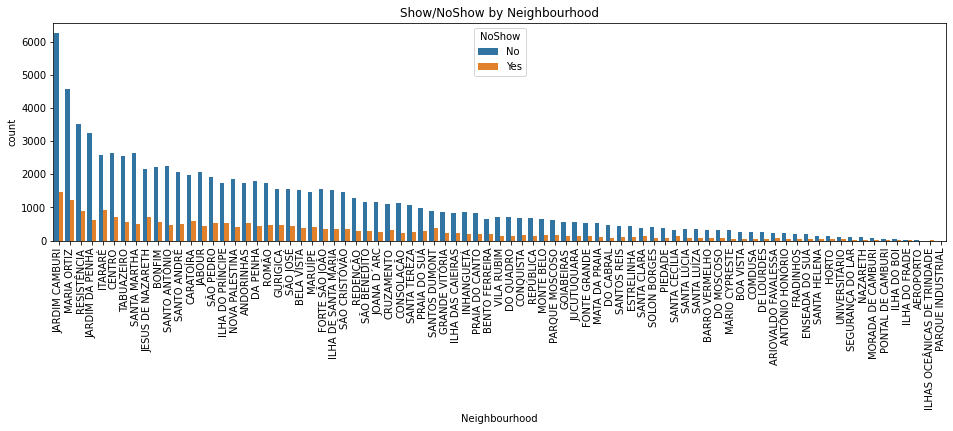

In [35]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.countplot(x=NSdf.Neighbourhood, hue=NSdf.NoShow, order=NSdf.Neighbourhood.value_counts().index)
ax.set_title("Show/NoShow by Neighbourhood")
plt.show()

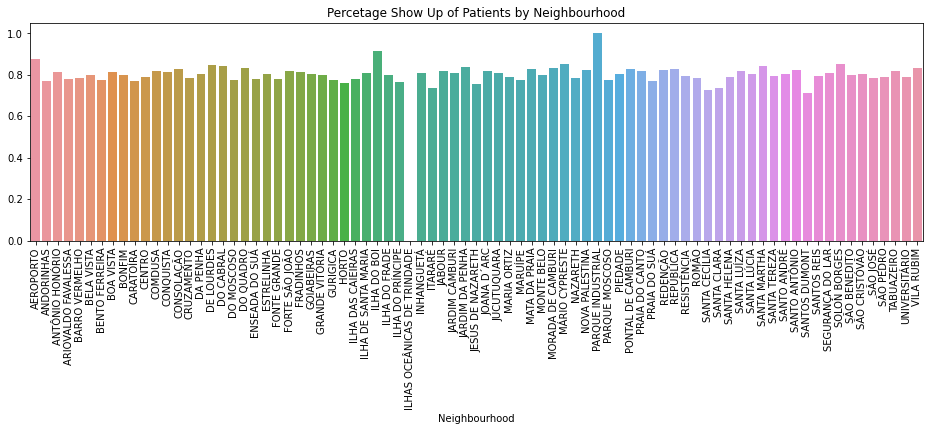

In [36]:
#지역에서 노쇼 비율
NSdf_n_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Neighbourhood']).size()/NSdf.groupby(['Neighbourhood']).size()
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ax = sns.barplot(x=NSdf_n_ratio.index, y=NSdf_n_ratio)
ax.set_title("Percetage Show Up of Patients by Neighbourhood")
plt.show()

지역에 상관없이 80%의 환자가 예약을 이행하고 있다.

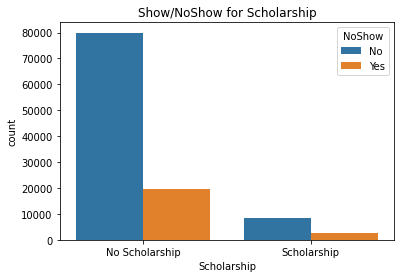

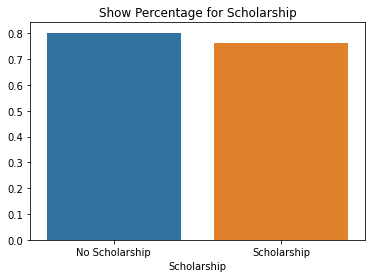

In [37]:
ax = sns.countplot(x=NSdf.Scholarship, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()
NSdf_s_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Scholarship']).size()/NSdf.groupby(['Scholarship']).size()
ax = sns.barplot(x=NSdf_s_ratio.index, y=NSdf_s_ratio)
ax.set_title("Show Percentage for Scholarship")
x_ticks_labels=['No Scholarship', 'Scholarship']
ax.set_xticklabels(x_ticks_labels)
plt.show()

장학금을 받은 적이 없으면 80%, 장학금을 받은 적이 있으면 75% 정도로 예약을 이행하고 있다. 브라질에서는 하위계층에게 장학금을 지급하므로 하위계층일수록 노쇼가 높다.

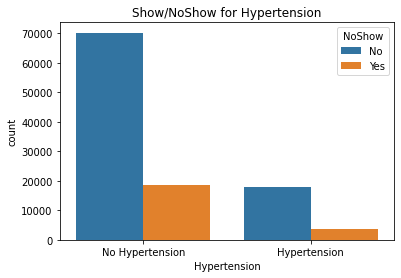

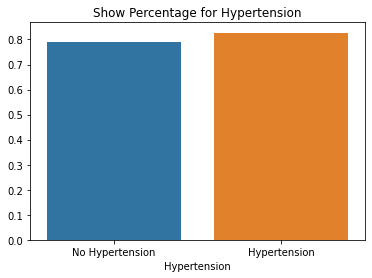

In [38]:
ax = sns.countplot(x=NSdf.Hypertension, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()
NSdf_h_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Hypertension']).size()/NSdf.groupby(['Hypertension']).size()
ax = sns.barplot(x=NSdf_h_ratio.index, y=NSdf_h_ratio)
ax.set_title("Show Percentage for Hypertension")
x_ticks_labels=['No Hypertension', 'Hypertension']
ax.set_xticklabels(x_ticks_labels)
plt.show()

고혈압이 없으면 79%, 있으면 85% 예약을 이행하고 있다. 고혈압이 있는 환자가 노쇼가 더 적은데, 병원에 더 자주 왕래하기 때문이라고 예상된다.

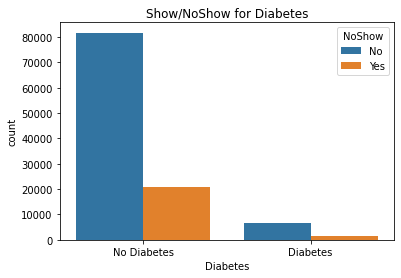

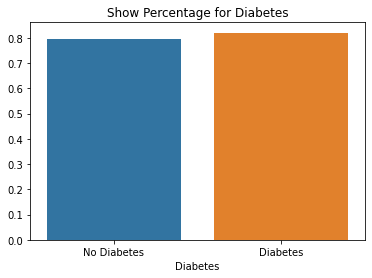

In [39]:
ax = sns.countplot(x=NSdf.Diabetes, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()
NSdf_d_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Diabetes']).size()/NSdf.groupby(['Diabetes']).size()
ax = sns.barplot(x=NSdf_d_ratio.index, y=NSdf_d_ratio)
ax.set_title("Show Percentage for Diabetes")
x_ticks_labels=['No Diabetes', 'Diabetes']
ax.set_xticklabels(x_ticks_labels)
plt.show()

당뇨가 없으면 80%, 있으면 83% 예약을 이행하고 있다. 고혈압과 마찬가지로 당뇨가 있는 사람이 노쇼가 적다.


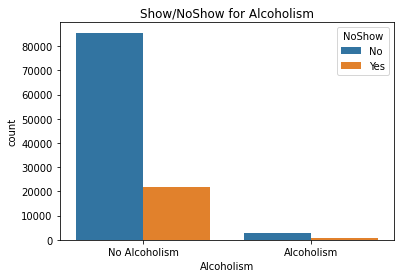

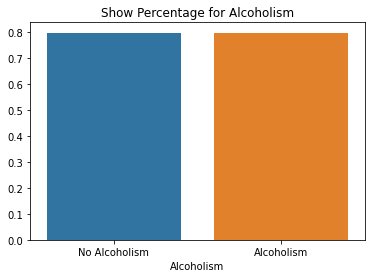

In [40]:
ax = sns.countplot(x=NSdf.Alcoholism, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()
NSdf_a_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Alcoholism']).size()/NSdf.groupby(['Alcoholism']).size()
ax = sns.barplot(x=NSdf_a_ratio.index, y=NSdf_a_ratio)
ax.set_title("Show Percentage for Alcoholism")
x_ticks_labels=['No Alcoholism', 'Alcoholism']
ax.set_xticklabels(x_ticks_labels)
plt.show()

알콜중독이든 아니든 예약 이행률은 80%로 비슷하다. 

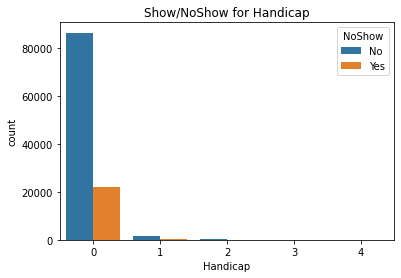

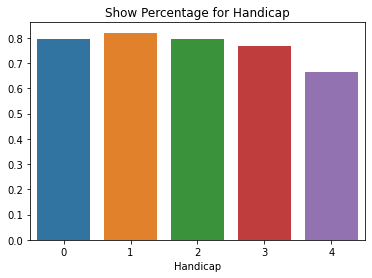

In [41]:
ax = sns.countplot(x=NSdf.Handicap, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for Handicap")
plt.show()
NSdf_ha_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Handicap']).size()/NSdf.groupby(['Handicap']).size()
ax = sns.barplot(x=NSdf_ha_ratio.index, y=NSdf_ha_ratio)
ax.set_title("Show Percentage for Handicap")
plt.show()

장애 레벨에 따라서 노쇼의 비율이 달라지는 것을 볼 수 있다.

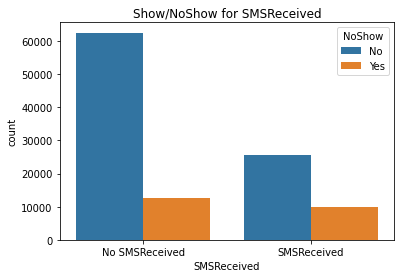

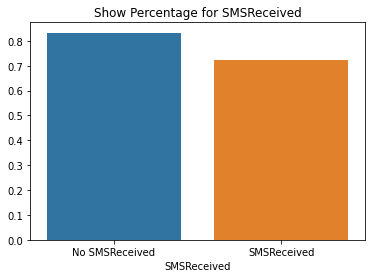

In [42]:
ax = sns.countplot(x=NSdf.SMSReceived, hue=NSdf.NoShow, data=NSdf)
ax.set_title("Show/NoShow for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()
NSdf_s_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['SMSReceived']).size()/NSdf.groupby(['SMSReceived']).size()
ax = sns.barplot(x=NSdf_s_ratio.index, y=NSdf_s_ratio)
ax.set_title("Show Percentage for SMSReceived")
x_ticks_labels=['No SMSReceived', 'SMSReceived']
ax.set_xticklabels(x_ticks_labels)
plt.show()

문자를 안받은 쪽이 84%, 받은 쪽이 72%로 예약을 이행하고 있다. 일반적으로 문자를 받으면 약속을 더 잘지킬 것 같지만 그와는 반대 결과이다. 예상컨데, 노쇼가 날 만한 상황이어서 문자를 보낸 것이 아닌가 싶다.

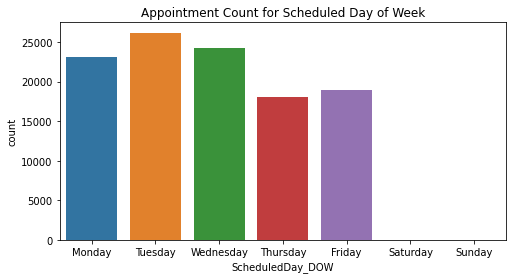

In [43]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=NSdf.ScheduledDay_DOW, order=week_key)
ax.set_title("Appointment Count for Scheduled Day of Week")
plt.show()

토요일 일요일은 예약건수가 없는 것을 보니 예약을 수행하는 직원들이 쉬는 날이다.

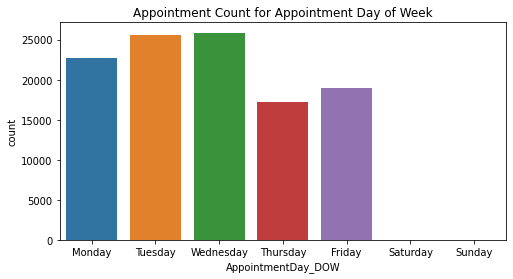

In [44]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=NSdf.AppointmentDay_DOW, order=week_key)
ax.set_title("Appointment Count for Appointment Day of Week")
plt.show()

진료날짜도 토요일과 일요일에는 없다. 의사들도 쉬는 날인 것 같다.

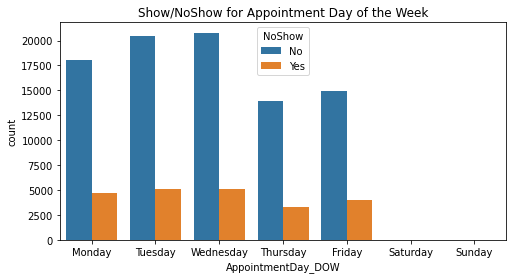

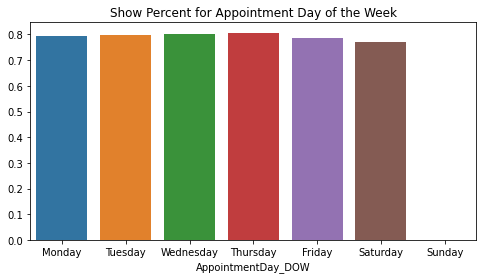

In [45]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x=NSdf.AppointmentDay_DOW, hue=NSdf.NoShow, order=week_key)
ax.set_title("Show/NoShow for Appointment Day of the Week")
plt.show()
NSdf_a_dow_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['AppointmentDay_DOW']).size()/NSdf.groupby(['AppointmentDay_DOW']).size()
plt.figure(figsize=(8,4))
ax = sns.barplot(x=NSdf_a_dow_ratio.index, y=NSdf_a_dow_ratio, order=week_key)
ax.set_title("Show Percent for Appointment Day of the Week")
plt.show()

토요일은 진료가 없는 것 같지만 노쇼 확률을 보니 토요일에도 아주 가끔 진료를 한다. 하지만 다른 요일보다 노쇼가 약간 많다.

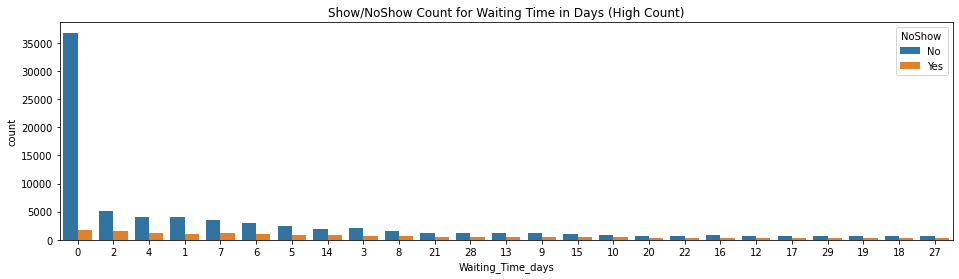

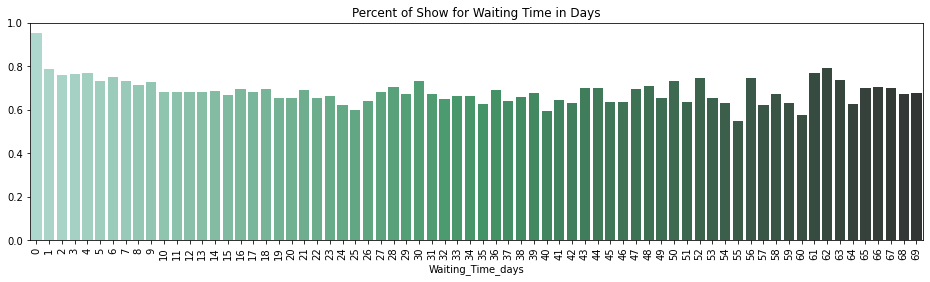

In [46]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x=NSdf.Waiting_Time_days, hue=NSdf.NoShow, order=NSdf.Waiting_Time_days.value_counts().iloc[:25].index)
ax.set_title("Show/NoShow Count for Waiting Time in Days (High Count)")
plt.show()

NSdf_w_ratio = NSdf[NSdf.NoShow == 'No'].groupby(['Waiting_Time_days']).size()/NSdf.groupby(['Waiting_Time_days']).size()
plt.figure(figsize=(16,4))
ax = sns.barplot(x=NSdf_w_ratio.index, y=NSdf_w_ratio, order=NSdf.Waiting_Time_days.iloc[:70].index, palette="BuGn_d")
ax.set_title("Percent of Show for Waiting Time in Days")
plt.xticks(rotation=90)
plt.show()

당일은 노쇼가 거의 없으며 1일부터 4일까지는 예약이행을 80%정도 유지하다가 그 이후로는 노쇼가 약간씩 많아진다.

In [47]:
NSdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Gender              110526 non-null  object        
 1   ScheduledDay        110526 non-null  datetime64[ns]
 2   AppointmentDay      110526 non-null  datetime64[ns]
 3   Age                 110526 non-null  int64         
 4   Neighbourhood       110526 non-null  object        
 5   Scholarship         110526 non-null  object        
 6   Hypertension        110526 non-null  object        
 7   Diabetes            110526 non-null  object        
 8   Alcoholism          110526 non-null  object        
 9   Handicap            110526 non-null  object        
 10  SMSReceived         110526 non-null  object        
 11  NoShow              110526 non-null  object        
 12  ScheduledDay_DOW    110526 non-null  object        
 13  AppointmentDay_DOW  110526 no

## 04_Modeling

In [48]:
NSdf.sample(10)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
83046,M,2016-05-02,2016-05-13,25,ITARARÉ,0,0,0,0,0,0,Yes,Monday,Friday,11
63700,F,2016-05-10,2016-05-12,16,DA PENHA,0,0,0,0,0,0,No,Tuesday,Thursday,2
18577,F,2016-05-18,2016-05-18,3,MARIA ORTIZ,0,0,0,0,0,0,No,Wednesday,Wednesday,0
56834,F,2016-04-27,2016-05-04,30,ILHA DO PRÍNCIPE,1,0,0,0,0,1,No,Wednesday,Wednesday,7
80493,F,2016-05-10,2016-05-13,57,JARDIM CAMBURI,0,0,0,0,0,0,Yes,Tuesday,Friday,3
87515,F,2016-06-02,2016-06-02,11,NOVA PALESTINA,0,0,0,0,0,0,No,Thursday,Thursday,0
107586,M,2016-05-31,2016-06-02,16,MONTE BELO,0,0,0,0,0,0,No,Tuesday,Thursday,2
103528,M,2016-06-01,2016-06-01,38,REDENÇÃO,0,0,0,0,0,0,No,Wednesday,Wednesday,0
22151,M,2016-05-09,2016-05-10,18,GURIGICA,0,0,0,0,0,0,Yes,Monday,Tuesday,1
26178,F,2016-05-04,2016-05-04,54,SANTA MARTHA,1,1,1,0,0,0,No,Wednesday,Wednesday,0


In [49]:
NSdf.sample(n=5)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days
1500,F,2016-04-20,2016-04-29,27,RESISTÊNCIA,0,0,0,0,0,1,No,Wednesday,Friday,9
38517,F,2016-04-08,2016-05-09,5,MARIA ORTIZ,0,0,0,0,0,0,No,Friday,Monday,31
47674,F,2016-04-26,2016-05-03,28,MARUÍPE,0,0,0,0,0,1,No,Tuesday,Tuesday,7
3553,F,2016-05-30,2016-05-30,15,RESISTÊNCIA,0,0,0,0,0,0,No,Monday,Monday,0
51408,M,2016-05-09,2016-05-09,36,FONTE GRANDE,0,0,0,0,0,0,No,Monday,Monday,0


In [50]:
le = LabelEncoder()
NSdf['Gender'] = le.fit_transform(NSdf['Gender'])
le = LabelEncoder()
NSdf['Neighbourhood'] = le.fit_transform(NSdf['Neighbourhood'])
le = LabelEncoder()
NSdf['ScheduledDay_DOW'] = le.fit_transform(NSdf['ScheduledDay_DOW'])
le = LabelEncoder()
NSdf['AppointmentDay_DOW'] = le.fit_transform(NSdf['AppointmentDay_DOW'])
le = LabelEncoder()
NSdf['NoShow'] = le.fit_transform(NSdf['NoShow'])

In [51]:
NSdf['ScheduledDay_Y'] = NSdf['ScheduledDay'].dt.year
NSdf['ScheduledDay_M'] = NSdf['ScheduledDay'].dt.month
NSdf['ScheduledDay_D'] = NSdf['ScheduledDay'].dt.day
NSdf.drop(['ScheduledDay'], axis=1, inplace=True)
NSdf['AppointmentDay_Y'] = NSdf['AppointmentDay'].dt.year
NSdf['AppointmentDay_M'] = NSdf['AppointmentDay'].dt.month
NSdf['AppointmentDay_D'] = NSdf['AppointmentDay'].dt.day
NSdf.drop(['AppointmentDay'], axis=1, inplace=True)
NSdf.sample(n=5)

,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time_days,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
86948,1,9,56,0,0,0,0,0,0,0,1,5,2,2016,6,6,2016,6,8
9995,1,50,23,0,1,0,0,0,0,0,5,5,0,2016,5,25,2016,5,25
68975,0,62,9,0,0,0,0,0,0,0,5,1,40,2016,3,23,2016,5,2
20099,0,29,68,0,0,0,0,0,1,0,0,4,4,2016,4,29,2016,5,3
17998,0,18,29,1,0,0,0,0,0,0,1,5,30,2016,4,18,2016,5,18


In [52]:
X = NSdf.drop(['NoShow'], axis=1)
y = NSdf['NoShow']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Decision Tree Classifier

In [54]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [55]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(dt_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

Gender -- 0.23
Age -- 0.22
Neighbourhood -- 0.18
Scholarship -- 0.08
Hypertension -- 0.08
Diabetes -- 0.05
Alcoholism -- 0.05
Handicap -- 0.03
SMSReceived -- 0.02
ScheduledDay_DOW -- 0.01
AppointmentDay_DOW -- 0.01
Waiting_Time_days -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [56]:
dt_clf.score(X_test, y_test)

0.7256400977110287

Random Forest Classfier

In [57]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
for name, importance in zip(X.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Gender -- 0.29
Age -- 0.26
Neighbourhood -- 0.13
Scholarship -- 0.06
Hypertension -- 0.05
Diabetes -- 0.04
Alcoholism -- 0.03
Handicap -- 0.03
SMSReceived -- 0.02
ScheduledDay_DOW -- 0.02
AppointmentDay_DOW -- 0.01
Waiting_Time_days -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [59]:
rf_clf.score(X_test, y_test)

0.7854428661901746

Grid Search CV

In [60]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rf_clf = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X, y)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   43.4s finished


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.7980656135365387
